# #KI-Werkbank
# Trennschärfe bei der Klassifizierung 

## Worum es hier geht
Ich habe in meinen letzten Blogs [Einstieg in neuronale Netze mit Keras](https://www.mt-ag.com/2018/11/14/einstieg-in-neuronale-netze-mit-keras/) zwei verschiedene Architekturen neuronaler Netzte auf die Sammlung handschriftlicher Ziffern von MNIST losgelassen. Ich möchte hier in diesem Mini Blog einen interessanten Unterschied im Ergebnis der beiden Modelle aufzeigen, nämlich die Trennschärfe
## Was ist die Trennschärfe einer Klassifikation?
Mit der Trennschärfe möchte ich ein Maß dafür dafür definieren, wie sicher sich ein neuronales Netz bei seinen Entscheidungen ist. Ich wir brauchen so ein Qualitätskriterium, um Netze miteinander vergleichen zu können. 

Ich lade dazu die beiden Modelle aus den letzten Versuchen ein und vergleiche sie miteinander um ein griffiges Maß für die Trennschärfe abzuleiten.

Neuronalen Netze sagen ihrer Antwort nicht so: „Du hast mir eine Zwei gezeigt“ sondern sie sagen: „Mit einer Wahrscheinlichkeit von 1% ist es eine Null, mit einer Wahrscheinlichkeit von 4% ist es eine Eins, mit einer Wahrscheinlichkeit von 91% ist es eine Zwei, mit …“. Oft ist sich das Modell nicht ganz sicher, um was es sich bei der Zahl handelt. Dann kann der Maximalwert vielleicht auch nur 21% sein. 

## Boilerplate Code

In [35]:
#tensorflow
import tensorflow as tf
from tensorflow.python.client import device_lib

#keras
import keras
from keras.backend.tensorflow_backend import set_session
from keras.datasets import mnist
from keras import models
from keras.models import model_from_json

#numpy
import numpy as np

#matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

#os
import os

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
                                    # (nothing gets printed in Jupyter, only if you run it standalone)
sess = tf.Session(config=config)

set_session(sess)

## Die trainierten Modelle laden

In [91]:
main_dir = os.path.normpath(os.getcwd() + os.sep + os.pardir)
mod_dir = os.path.join(main_dir,'train_model', 'persist_model')


def get_model(model_file, model_weights):
    # load json and create model
    with open(model_file, 'r', encoding='utf-8') as json_file:
        loaded_model_json = json_file.read()

    model = model_from_json(loaded_model_json)
    # load weights into new model
    model.load_weights(model_weights)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

simple_model = get_model(os.path.join(mod_dir, 'simple_MNIST_model.json'), os.path.join(mod_dir, 'simple_MNIST_model.h5'))
cnn_model = get_model(os.path.join(mod_dir, 'convolutional_MNIST_model.json'), os.path.join(mod_dir, 'convolutional_MNIST_model.h5'))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 324)               254340    
_________________________________________________________________
dense_2 (Dense)              (None, 36)                11700     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                370       
Total params: 266,410
Trainable params: 266,410
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_

## Die Testdaten laden und die Modelle befragen

In [92]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
simple_results = simple_model.predict(test_images)
cnn_results = cnn_model.predict(test_images.reshape((10000, 28, 28, 1)).astype('float32') / 255)

## Wie eindeutig sind die Ergebnisse
Zuerst werde ich einen naiven Blick auf die Histogramme der beiden Modelle, getrennt nach richtigen und falschen Vorhersagen. 

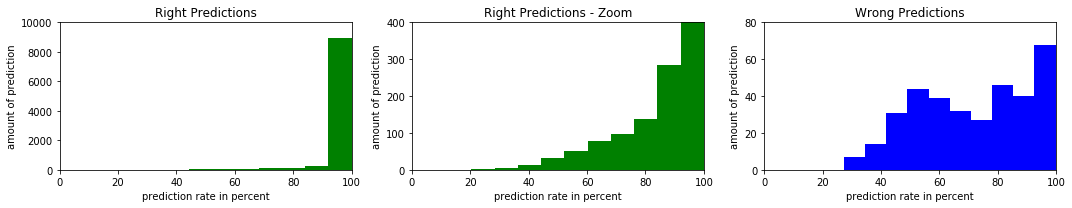

Abb 1: Trennschärfe der Vorhersage bei einem Fully Connected Neuron Network


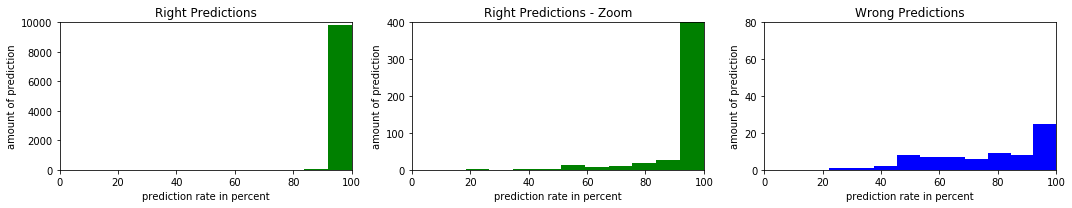

Abb 2: Trennschärfe der Vorhersage bei einem Convolutional Neuron Network


In [155]:
def show_hist(results, decs):
    _x = []
    _x_wrong = []
    for index, result in enumerate(results):
        predict = result.argmax()
        expect = test_labels[index]
        if predict == expect:
            _x.append(np.amax(result))
        else:
            _x_wrong.append(np.amax(result))
    x = np.array(_x)
    x_wrong = np.array(_x_wrong)

    fig, axes = plt.subplots(nrows = 1 , ncols = 3, figsize=(15, 3))
    ax0, ax1, ax2 = axes.flatten()

    ax0.hist(x * 100, facecolor='g')
    ax0.set_title('Right Predictions')
    ax0.set_xlabel('prediction rate in percent')
    ax0.set_ylabel('amount of prediction')
    ax0.axis([0, 100, 0, 10000])

    ax1.hist(x * 100, facecolor='g')
    ax1.set_title('Right Predictions - Zoom')
    ax1.set_xlabel('prediction rate in percent')
    ax1.set_ylabel('amount of prediction')
    ax1.axis([0, 100, 0, 400])

    ax2.hist(x_wrong * 100, facecolor='b')
    ax2.set_title('Wrong Predictions')
    ax2.set_xlabel('prediction rate in percent')
    ax2.set_ylabel('amount of prediction')
    ax2.axis([0, 100, 0, 80])

    fig.tight_layout()
    plt.show()    
    print(decs)

    
show_hist(simple_results, "Abb 1: Trennschärfe der Vorhersage bei einem Fully Connected Neuron Network")
show_hist(cnn_results, "Abb 2: Trennschärfe der Vorhersage bei einem Convolutional Neuron Network")

Nach rechts ist die Genauigkeit der Vorhersage aufgetragen. Die 100 bedeutet also, dass sich das Modell mit einer Sicherheit von 100% auf eine bestimmte Ziffer festgelegt hat. 

Nach oben habe ich die totale Anzahl der Vorhersagen aufgetragen. Für das CNN in Abb 2 sieht man zum Beispiel, dass 10.000 Vorhersagen getroffen wurden, bei dem sich das Modell zu 100% sicher war.

Beim jeweils zweiten Histogramm habe ich ein wenig in die untere rechte Ecke hineingezoomt, um hervorzuheben, wo die Unschärfen liegen. Man erkennt sehr deutlich, dass sich das CNN mit seinen Vorhersagen viel sicherer ist, als das einfache NN. 

Beim jeweils dritten Histogramm habe ich das gleiche Spiel für die falsch vorhergesagten Ziffern aufgetragen. Dummerweise ist sich hier das CNN auch viel sicherer mit seiner Vorhersage. 


## Eine eindeutige Maßeinheit

Es stellt sich nun die Frage, wie man möglichst griffig die Trennschärfe eines Modells angibt. Ich denke, der einfache Mittelwert minus des kleinsten Mittelwertes auf [0,1] skaliert ist ein gutes Maß dafür und zwar aus folgenden einfachen Gründen:
-	Die Summe aller Wahrscheinlichkeiten pro Vorhersage ist immer 100% 
-	Ist eine Vorhersage also 100%, sind alle anderen Wahrscheinlichkeiten 0%
-	Die kleinste Vorhersage muss immer ein klein wenig größer als 100 % geteilt durch die Anzahl der Möglichkeiten sein (in unserem Fall 100% / 10 verschiedene Ziffern = 10% plus ein kleines Delta)
-	Eine Trennschärfe von 100% heißt dann, dass sich das Modell absolut sicher ist
-	Eine Trennschärfe von 0% heißt, dass es alles oder nichts sein kann.

Somit ergeben sich für die beiden Modelle folgende Trennschärfen:

In [167]:
def show_hist(results, desc):
    _x = []
    for index, result in enumerate(results):
        predict = result.argmax()
        expect = test_labels[index]
                
        if predict == expect:
            _x.append(np.amax(result))

    
    x = np.mean(np.array(_x) * 100 - 100 / 10) * 100 / 90
    print(desc.format(x))

    
show_hist(simple_results, "Die Trennschärfe des Fully Connected Neuron Networkfür richtige Vorhersagen ist: {:.2f}%.\n")
show_hist(cnn_results, "Die Trennschärfe des Convolutional Neuron Network für richtige Vorhersagen: {:.2f}%.\n")

Die Trennschärfe des Fully Connected Neuron Networkfür richtige Vorhersagen ist: 97.33%.

Die Trennschärfe des Convolutional Neuron Network für richtige Vorhersagen: 99.69%.



## Schluss
Die Convolutions im CNN haben für den Fully Connecte Teil die Freiheitsgrade stark eingeschränkt. Den Erfolg dieser Übung erkennt man nicht nur in den besseren Testergebnissen, sondern auch in der Trennschärfe. Damit ist er ein wichtiges Maß für die Richtigkeit der gewählten Netzarchitektur. 

# SCHLAGWÖRTER
KI, AI, ML, Keras, TensorFlow, DNN, Deep Learning, Neuronale Netze, Tutorial, MNSIST, Dens Layer, CNN, Convolution

# BESCHREIBUNG
Ich zeige, wie man eine Aussage über die Trennschärfe einer Vorhersage treffen kann.

# KATEGORIEN
Architektur, BI & DWH, Blog, Business Intelligence, KI